In [1]:
%load_ext autoreload
%autoreload 2

# UMAPS for cvae multi of adaptation model

In [2]:
from evoscaper.scripts.init_from_hpos import init_from_hpos
from evoscaper.utils.math import arrayise
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from common import get_model_latent_space_dimred, load_stitch_ys, load_stitch_analytics
from evoscaper.utils.visualise import visualize_dimred_adapt_sp
from evoscaper.utils.preprocess import make_datetime_str, format_with_subscript

from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import os

sns.set_style('whitegrid')


In [3]:
top_write_dir = os.path.join('data', '22_umaps_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

idx_output = -1

# Load data 

In [4]:
# fn_dataset = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
# dataset = load_json_as_dict(fn_dataset)

# Functions for loading models

In [5]:
dir_verify = 'data/cvae_multi/2025_09_01__22_52_46' # adaptation
dir_verify = 'data/cvae_multi/2025_09_02__15_42_30' # adaptation2
dir_verify = 'data/cvae_multi/2025_09_03__11_20_07' # adaptation3
dir_verify = 'data/cvae_multi/2025_09_03__12_42_01' # adaptation4
dir_verify = 'data/cvae_multi/2025_09_05__13_20_35' # adaptation3 but more samples
dir_verify = 'data/cvae_multi/2025_09_05__17_06_45' # adaptation3b

fn_hpos = os.path.join(dir_verify, 'df_hpos.json')
hpos = pd.DataFrame(load_json_as_dict(fn_hpos))
for k in hpos.columns:
    if 'filename' in k:
        hpos.loc[:, k] = hpos[k].apply(lambda x: '../' + x if x.startswith('data') else x)
        hpos.loc[:, k] = hpos[k].apply(lambda x: x.replace('notebooks/', '') if isinstance(x, str) else x)
(
    rng, rng_model, rng_dataset,
    config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
    data, x_cols, df,
    x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
    total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
    params, encoder, decoder, model, h2mu, h2logvar, reparam
) = init_from_hpos(hpos.iloc[1])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
def load_params(hpo):

    fn_saves = hpo['filename_saved_model']
    saves_loaded = load_json_as_dict(fn_saves)
    p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
    p = arrayise(p)
    
    return p

# Function for visualising KDE

In [7]:
all_fake_circuits = np.load(os.path.join(dir_verify, 'fake_circuits.npy'))
all_sampled_cond = np.concatenate([np.load(os.path.join(dir_verify, 'sampled_cond', fn))
                                  for fn in sorted(os.listdir(os.path.join(dir_verify, 'sampled_cond')),
                                                   key=lambda x: int(x.split('_')[-1].split('.')[0]))], axis=0)
analytics = load_stitch_analytics(os.path.join(
    dir_verify, 'batch_results'), last_idx=idx_output)

# n_interactions = make_flat_triangle(all_fake_circuits).shape[-1]
# n_perturbs = config_bio['n_perturbs'] if not config_rugg['perturb_once'] else n_interactions + config_rugg['resimulate_analytics']

# ys_out, ts = load_stitch_ys(os.path.join(
#     dir_verify, 'batch_results'), idx_output, len(all_fake_circuits))

In [19]:
hpos[hpos[['seed_train', 'seed_arch']].apply(tuple, axis=1).isin([(3, 2), (5, 12), (1, 25)])].index.to_numpy().astype(int)

array([ 14,  56, 112])

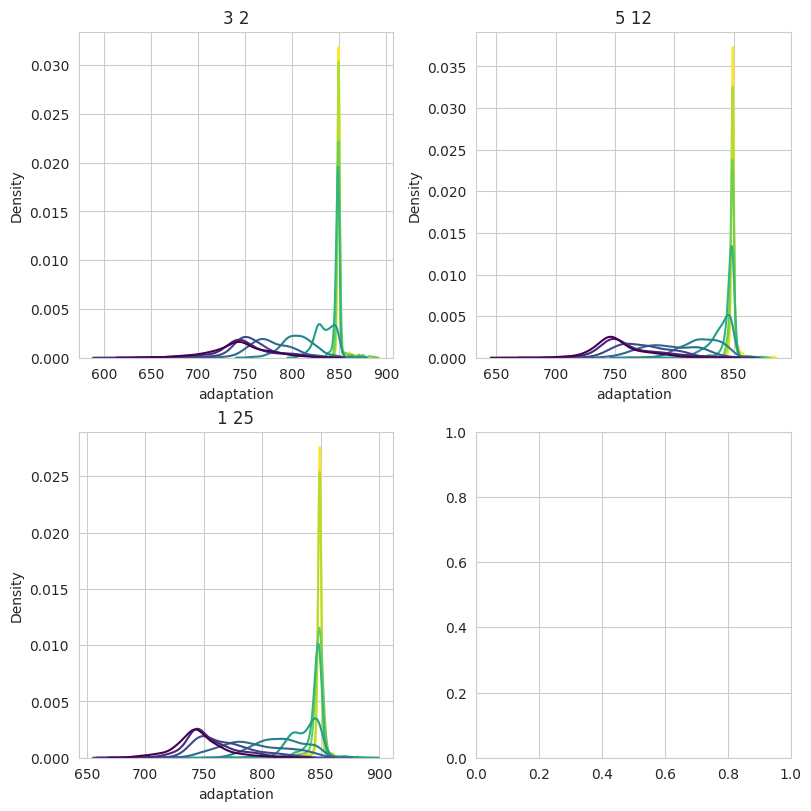

In [20]:
df_plot = pd.DataFrame()
df_plot['Model'] = np.repeat(hpos.index.to_numpy().astype(int), repeats=np.array(analytics['Log sensitivity']).reshape(len(hpos), -1).shape[-1]) 
df_plot['Prompt'] = all_sampled_cond.flatten().round(2)
df_plot['adaptation'] = np.array(analytics['adaptation']).reshape(len(hpos), -1).flatten()

# midxs = sorted(df_plot['Model'].unique())
midxs = hpos[hpos[['seed_train', 'seed_arch']].apply(tuple, axis=1).isin([(3, 2), (5, 12), (1, 25)])].index.to_numpy().astype(int)
nrows = int(np.ceil(np.sqrt(len(midxs))))
ncols = int(np.ceil(len(midxs) / nrows))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True)
for m, ax in zip(midxs, axs.flatten()):
    sns.kdeplot(data=df_plot[df_plot['Model'] == m], x='adaptation', hue='Prompt', palette='viridis', ax=ax, legend=False)
    ax.set_title(' '.join([str(hpos.loc[str(m)]['seed_train']), str(hpos.loc[str(m)]['seed_arch'])]))
plt.savefig(os.path.join(top_write_dir, 'kde_adapt.png'), dpi=300, transparent=False)



In [9]:
# from functools import partial
# seeds_good = [(5, 1), (9, 1), (3, 2), (0, 2), (3, 3), (4, 3), (6, 3), (9, 5), (3, 5), (0, 12), (9, 12), (6, 12), (5, 17), (9, 17), (4, 18), (0, 20), (0, 22), (9, 20), (3, 25), (6, 25), ]
# seeds_ok = [(0, 25), (1, 3), (1, 11), (4, 5), (4, 17)]
# seeds_hmm = [(6, 5), (1, 17), (2, 25)]

# midxs_good = hpos[hpos[['seed_train', 'seed_arch']].apply(tuple, axis=1).isin(seeds_good)].index.to_numpy().astype(int)
# nrows = int(np.ceil(np.sqrt(len(midxs_good))))
# ncols = int(np.ceil(len(midxs_good) / nrows))
# for hist_type in ['hist', 'kde']:
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), constrained_layout=True)
#     f_plot = sns.kdeplot if hist_type == 'kde' else partial(sns.histplot, bins=50, element='step')
#     for m, ax in zip(midxs_good, axs.flatten()):
#         f_plot(data=df_plot[df_plot['Model'] == m], x='adaptation', hue='Prompt', palette='viridis', ax=ax, legend=False)
#         ax.set_title(' '.join([str(hpos.iloc[m]['seed_train']), str(hpos.iloc[m]['seed_arch'])]))
#     plt.savefig(os.path.join(top_write_dir, f'{hist_type}_adapt_good.png'), dpi=300, transparent=False)
#     plt.close()


## Investigate weird outputs 

One model had a circuit with an adaptation of ca. -2000 and negative steady states. Upon closer inspection of the time series, this is due to insufficiently small dt in simulation when y is near 0. 

In [10]:
# from common import load_stitch_ys

# ys_out, ts = load_stitch_ys(os.path.join(dir_verify, 'batch_results'), idx_output=-1, n_samples=len(all_fake_circuits))

# plt.plot(ys_out[np.where(ys_out < 0)[0]][200:300].squeeze().T)
# plt.title('ys going negative')
# plt.xlabel('t')
# plt.ylabel('y_out')

# plt.show()

# Functions for UMAP + visualisation

In [11]:
use_h = False
perplexity = 30
n_show = 20000
random_state = 0
method = 'UMAP'
input_species = data['sample_name'].dropna().unique()
labels_x = list(itertools.product(input_species, input_species))
labels_x = sorted(set(tuple(sorted(labels_x[i]))
                for i in range(len(labels_x))))
labels_cond = ['adaptation', 'Log sensitivity', 'Log precision']


In [12]:
def run_umap(hpo):
    p = load_params(hpo)
    result_dimred, idxs_show, cond_unique, cond_binned, x_bin_all, x_rev_all, cond_rev_all, emb, h_all, z_all = get_model_latent_space_dimred(
        p, rng, encoder, h2mu, h2logvar,
        x, cond, use_h,
        y_datanormaliser, y_methods_preprocessing,
        config_dataset, x_datanormaliser, x_methods_preprocessing,
        hpo,
        method=method, n_show=n_show, random_state=random_state,
        perplexity=perplexity
    )
    print(idxs_show.shape)

    visualize_dimred_adapt_sp(result_dimred, df[labels_cond].values[idxs_show],
                              np.log10(
                                  x_bin_all[idxs_show]) if config_norm_x.logscale else x_bin_all[idxs_show],
                              labels_cond=labels_cond,
                              labels_x=labels_x, method=method,
                              save_path=os.path.join(top_write_dir, f'umap_big_{hpo["index"]}.png'), s=70, sort=False, sort_random=True)

# Loop for loading and visualising

In [13]:
# for i in hpos.index:
#     hpo = hpos.iloc[[i]].reset_index().iloc[0].to_dict()
#     p = run_umap(hpo)